# Выпускной Проект «Промышленность»

## Введение

В данном выпускном проекте мы решим задачу по доменной области "Промышленность".

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали. 

Ниже можно найти описание задачи, а также примерное содержание данного файла.

<b>Описание этапа обработки</b>

- Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

- Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

- Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

- Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


<b>Содержание данного нотбука:</b>
- Изучение общей информации о файлах с данными.
- Изучение столбцов и проверка данных.
- Анализ задачи и формирование дальнейшего плана действий.
- Подготовка данных для обучения моделей.
- Обучение моделей.
- Тестирование итоговой модели.
- Выводы проекта.

<b>Автор проекта:</b>
- Виктория Кускова, 
- студентка Яндекс.Практикума, 2021.

## Изучение данных

### Загрузка данных

Выделим библиотеки, которые понадобятся нам в этой части проекта в отдельную ячейку.

In [1]:
#импорты библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
#from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Импортируем данные и изучим их. У нас есть всего 7 файлов с информацией.

In [2]:
#импорт файлов с данными
df_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
df_arc.name = 'Данные об электродах, df_arc'
df_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
df_bulk.name = 'Данные о подаче сыпучих материалов (объём), df_bulk'
df_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
df_bulk_time.name = 'Данные о подаче сыпучих материалов (время), df_bulk_time'
df_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
df_gas.name = 'Данные о продувке сплава газом, df_gas'
df_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
df_temp.name = 'Результаты измерения температуры, df_temp'
df_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
df_wire.name = 'Данные о проволочных материалах (объём), df_wire'
df_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
df_wire_time.name = 'Данные о проволочных материалах (время), df_wire_time'

In [3]:
list_df = [df_arc, df_bulk, df_bulk_time, df_gas, df_temp, df_wire, df_wire_time]

Данные импортировали, посмотрим на них внимательно. Начнем с общих данных.

In [4]:
#изучаем размеры таблиц
for i in list_df:
    print(i.name)
    print(i.shape)

Данные об электродах, df_arc
(14876, 5)
Данные о подаче сыпучих материалов (объём), df_bulk
(3129, 16)
Данные о подаче сыпучих материалов (время), df_bulk_time
(3129, 16)
Данные о продувке сплава газом, df_gas
(3239, 2)
Результаты измерения температуры, df_temp
(15907, 3)
Данные о проволочных материалах (объём), df_wire
(3081, 10)
Данные о проволочных материалах (время), df_wire_time
(3081, 10)


Видим по форме таблиц, что:
- Основная таблица с измерениями температуры df_temp, где вероятнее всего находится целевой признак, содержит около 15 тыс. строк.
- Таблицы о проволочных материалах по объему и времени имеют одинаковое число строк - 3081. Это хороший признак, скорее всего наблюдения не потерялись.
- Таблицы о сыпучих материалах по объему и времени тоже имеют одинаковое число строк - 3129. Это также хорошо.
- Данные об электродах содержат число строк более близкое к числу строк в таблице с температурой 14 тыс. А данные о газе более похожее число на таблицы про материалы - 3239.

Посмотрим на таблицы внимательнее.

### Таблица "Данные об электродах, df_arc"

Посмотрим внимательно на данные об электродах.

In [5]:
df_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


5 столбцов, пропусков нет.

In [6]:
df_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


- Видим, что данные по партиям (столбец key) повторяется - это значит для обной партии могло быть несколько нагревов дугой.
- Типа мощности у нас две: активная и реактивная. Мы можем использовать эти мощности как отдельные признаки для модели, так и посчитать полную мощность, а также работу, вычислив по столбцам со временем, время.
- Важно при вычислениях правильно агрегировать признаки. Полную мощность получаем как корень из суммы квадратов активной и реактивной мощности. 

Посмотрим на распределение значений мощности при нагревах.

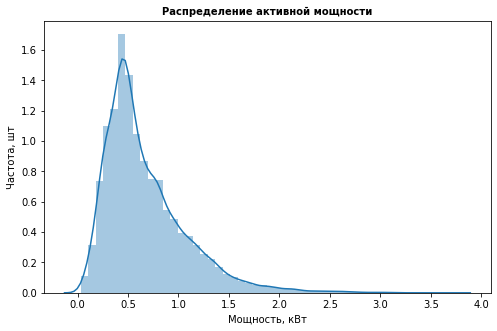

In [7]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение активной мощности", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_arc['Активная мощность'],kde=True, rug=False, axlabel="Мощность, кВт")
plt.show()

Видим, что для активной мощности нет неправдоподобных выбросов и пиков в распределении. 

Большинство значений, основной пик расположен около 0,5 кВт.

Посмотрим на реактивную мощность.

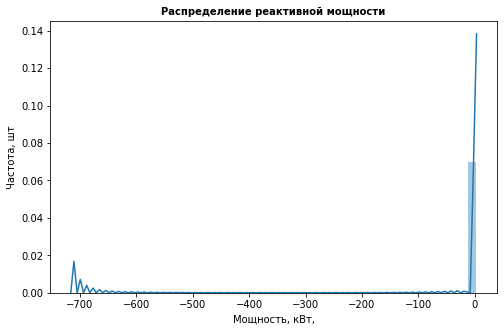

In [8]:
plt.figure(figsize=(8, 5))
plt.title("Распределение реактивной мощности", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_arc['Реактивная мощность'],kde=True, rug=False, axlabel="Мощность, кВт,")
plt.show()

Видим большой пик в 0, и один меньший в около -700. Посмотрим на занчения меньше 0 внимательнее. Отрицательная мощность - это то, что нужно проверить.

Пик в 0 вероятно соответсвует тому, что реактивной можности при нагреве не возникло. И это хорошо, что у большиства партий ее значение именно 0. Но нужно подтвердить это наблюдение с заказчиком.

In [9]:
df_arc[df_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Видим, что это всего одна строка. Возможно это отрицательное значение попалао сюда по ошибке при миграции даных. Вероятно эту строку, а также и всю партию нужно удалить, так как у нас неправильные и неправдоподобные данные по ней. Но необходимо уточнить это у бизнеса. 

Запомним эту партию: 2116 и значение реактивной мощности -715. Вероятно удалим ее из расчетов.

Теперь посмотрим на распределение без отрицательных значений и пиков в 0.

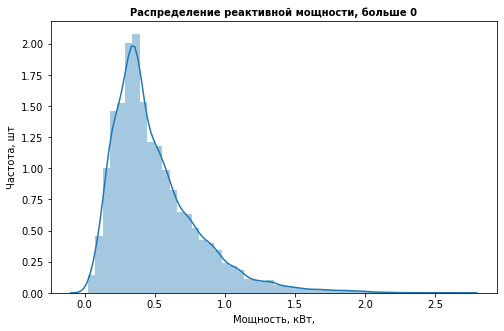

In [10]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(8, 5))
plt.title("Распределение реактивной мощности, больше 0", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_arc[df_arc['Реактивная мощность'] > 0]['Реактивная мощность'],
             kde=True, rug=False, axlabel="Мощность, кВт,")
plt.show()

Теперь распределение стало очень похоже на распределение активной мощности. Только значение пика - 2 кВт, что больше, чем было у активной. Нет неправдоподобных выбросов и пиков в распределении, вероятно данные корректы.

Уточним у заказчиков также, правильно ли по их ощущениям, что приблизительно в среднем значение активной мощности для большинства партий - 0,5 кВт, а для реактивной (если она есть) - 2 кВт.

### Данные о подаче сыпучих материалов (объём и время), df_bulk и df_bulk_time

Посмотрим на обе таблицы по сыпучим материалам вместе.

In [11]:
df_bulk.info(), df_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7 

(None, None)

In [12]:
df_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [13]:
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Видим по данным таблицам следующее:
- В обоих таблицах присутсвуют пропуски, но на первый взгляд они совпадают. (Проверим это точно ниже).
- Вероятно пропуски тут соответсвуют тому, что материал, соответсвующий этому столбцу просто не добавляли. (Что конечно в рельной жизни необходимо подтвердить у бизнеса). При необходимости в дальнейшем заменим их на 0.
- Видим, что данные в этих таблицах агрегированные уже до партий. Это видно также по тому, что время в строках отличается в рамках одной партии - значит 1 строка уже содержит несколько итераций.


Проверим что Nan находятся в одинаковых местах. Посмотрим на чило пропусков отдельнов каждой таблице, а также на число пропусков в одинаковых местах. Если они совпадут - значит, все так.

In [14]:
counter_1 = 0
counter_2 = 0
counter_both = 0

#для таблицы с количетствами можно применить функцию isnan из numpy
for i in range(1,16):
    for j in range(3129):
        if np.isnan(df_bulk.iloc[j,i]) == True:
            counter_1 += 1

#для таблицы с временем isnan из numpy не подойдет (не числовые значения), используем другой не такой компактный метод 
for i in range(1,16):
    for j in range(3129):
        if (df_bulk_time.iloc[j,i] == df_bulk_time.iloc[j,i]) == False:
            counter_2 += 1
            
for i in range(1,16):
    for j in range(3129):
        if np.isnan(df_bulk.iloc[j,i]) == True and (df_bulk_time.iloc[j,i] == df_bulk_time.iloc[j,i]) == False:
            counter_both += 1
            
counter_1, counter_2, counter_both

(35776, 35776, 35776)

Значение совпали - пропуски в одинаковых местах. Это хорошо. Посмотрим теперь внимательнее на таблицу с объемом сыпучих материалов. Если там неправдоподобные значения. Для этого посмотрим на максимумы, минимумы и др.

In [15]:
df_bulk.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


Подозрительный максимум и большое отклонение (больше 100) есть у столбцов: Bulk 7 и Bulk 12.
Причем у 7 только 25 партий с добавлением, и вероятно такое отклонение из-за малого числа данных. А вот 12 материал один из самых популярных, и его неправдоподобно большое значение следует внимательно посмотреть.

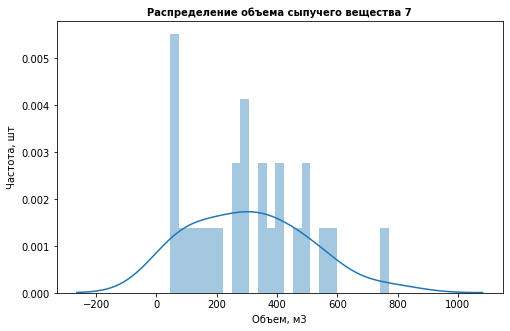

In [16]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение объема сыпучего вещества 7", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_bulk[df_bulk['Bulk 7'].notnull()]['Bulk 7'],kde=True, bins = 25, rug=False, axlabel="Объем, м3")
plt.show()

Мы сделли число корзин тут = числу партий с этим материалом. Да, видим, что значений немного. Но максимум не так далеко от других значений, в целом некоторые значения встречаются 2-3 раза или 1. В целом неправдоподобных значений не видно. будем считать, что с этим столбцом все хорошо.

Посмотрим на 12.

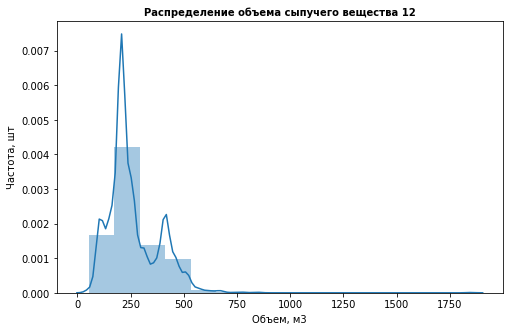

In [17]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение объема сыпучего вещества 12", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_bulk[df_bulk['Bulk 12'].notnull()]['Bulk 12'],kde=True, bins=15, rug=False, axlabel="Объем, м3")
plt.show()

Явно есть неправоподобные большие, которые лежат далеко от других данных. Посмотрим внимательнее на них.

In [18]:
df_bulk[df_bulk['Bulk 12'] > 1000]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN


Опять же это всего 1 партия - 322. Запомним ее и исключим при расчетах моделей, согласовав с бизнесом.

Посмотрим на данные без нее.

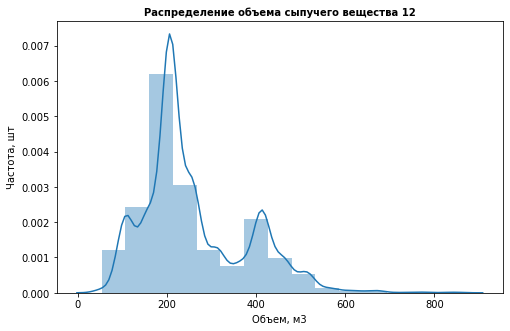

In [19]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение объема сыпучего вещества 12", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_bulk[(df_bulk['Bulk 12'].notnull())&(df_bulk['Bulk 12'] < 1000)]['Bulk 12'],
             kde=True, bins=15, rug=False, axlabel="Объем, м3")
plt.show()

Видим 2 пика в 200 м3 и 400 м3, возможно это значения около кратных 200 - возможно это величины "посуды", которой подсыпают материал.
Видим, что все еще есть хвост около 800, но он уже не выглядит не так неправдоподобно. Пока остаим его, но лучше всего будет обсудить этот график распределния с бизнесом. 

### Данные о продувке сплава газом, df_gas

In [20]:
df_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
df_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


Видим, что данные уже агрегированные и пропусков нет. Посмотрим на распределение.

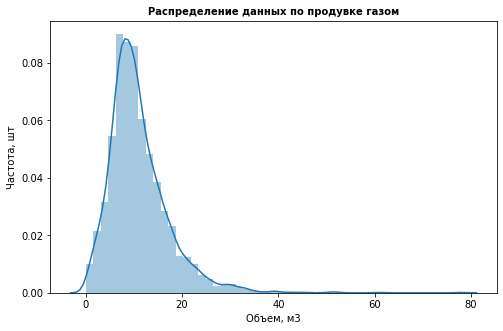

In [22]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение данных по продувке газом", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_gas['Газ 1'],kde=True, rug=False, axlabel="Объем, м3")
plt.show()

Неправдоподобных пиков нет. Посмотрим на максимум дополнительно.

In [23]:
df_gas[df_gas['Газ 1'] > 50]

,key,Газ 1
116,117,50.581035
277,280,60.935689
319,322,77.995040
2107,2110,52.142373
2567,2570,51.380229


Видим, что в максимум попала опять партия 322, которая уже вызывала у нас сомнения. Ее мы удалим, а другие значения оставим.

### Результаты измерения температуры, df_temp

In [24]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [25]:
df_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Данные не агрегированны до партий, видим замеры температуры на разных шагах.

Видим, что есть пропуски, около 3 тыс в значениях с температурой. Посмотрим сколько это уникальных партий. И сколько это относительно всех партий.

In [26]:
len(df_temp['key'].unique()), len(df_temp[df_temp['Температура'].isnull()]['key'].unique())

(3216, 739)

У около 23% отсутвует значение температуры на ком-то из этапов. Посмотрим, что это за партии.

In [27]:
df_temp[df_temp['Температура'].isnull()]['key'].unique()

array([2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
       2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
       2522, 2523, 2524, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532,
       2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543,
       2544, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2576,
       2577, 2578, 2579, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587,
       2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2596, 2597, 2598,
       2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609,
       2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620,
       2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2631,
       2632, 2633, 2634, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642,
       2643, 2644, 2645, 2646, 2647, 2648, 2649, 26

Это все партии с номером после 2500 - возможно начиная с этой партии возникла тех. ошибка. Или эти партии при сборе данных еще были в работе и данных по замерам нет из-за этого.


Для нашей моели самый важный фактов - изначальная температура и конечная (целевой признак). Температурой на других этапах можно пренебречь, более того - это излишняя информация для прогнозирования, так как это уже утечка целевого признака, который мы предсказываем.

Давайте найдем партии, где нет начальной или конечной температуры. Для этого для каждый партии вычислим первый и последний замер, и добавим метку об этом в таблицу с температурой.

In [28]:
key_info = (df_temp.pivot_table(index='key', values='Время замера', aggfunc=[min, max])
             .reset_index()
            )

key_info.columns = ['key', 'Замер температуры первый','Замер температуры последний']

In [29]:
key_info.head()

,key,Замер температуры первый,Замер температуры последний
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01


In [30]:
df_temp = pd.merge(df_temp, key_info, how='outer')
df_temp.head()

,key,Время замера,Температура,Замер температуры первый,Замер температуры последний
0,1,2019-05-03 11:16:18,1571.0,2019-05-03 11:16:18,2019-05-03 11:30:39
1,1,2019-05-03 11:25:53,1604.0,2019-05-03 11:16:18,2019-05-03 11:30:39
2,1,2019-05-03 11:29:11,1618.0,2019-05-03 11:16:18,2019-05-03 11:30:39
3,1,2019-05-03 11:30:01,1601.0,2019-05-03 11:16:18,2019-05-03 11:30:39
4,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,2019-05-03 11:30:39


Добавили информацию по первому замеру для партии. Посмотрим теперь сколько партий, к которых нет информации по первому или последнему. Всего у нас было 739 пропусков температуры из 3216 партий.

In [31]:
len(df_temp[(df_temp['Время замера']==df_temp['Замер температуры первый'])&(
    df_temp['Температура'].isnull())]['key'].unique())

0

In [32]:
len(df_temp[(df_temp['Время замера']==df_temp['Замер температуры последний'])&(
    df_temp['Температура'].isnull())]['key'].unique())

739

Видим, что у всех партий с пропусков пропущен последний замер. Да, вероятно по этим последним партиям просто рано мигрировали данные, пока замеры по последним этапам еще производились или прогружались.

Сообщим об этом, но для модели удалим.

Посмотри также на распределния температур.

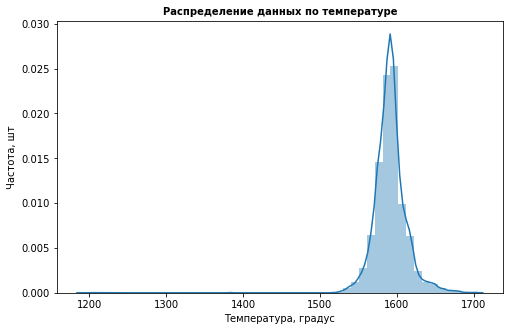

In [33]:
fig = plt.figure(figsize=(8, 5))
plt.title("Распределение данных по температуре", fontweight='bold', size='medium')
plt.ylabel("Частота, шт")
sns.distplot(a=df_temp[df_temp['Температура'].notnull()]['Температура'],kde=True, rug=False, axlabel="Температура, градус")
plt.show()

Видим длинный хвост около 1200.

In [34]:
df_temp[df_temp['Температура'] < 1500]

,key,Время замера,Температура,Замер температуры первый,Замер температуры последний
4350,867,2019-06-04 14:21:00,1191.0,2019-06-04 14:21:00,2019-06-04 14:57:17
5978,1214,2019-06-16 05:32:00,1208.0,2019-06-16 05:32:00,2019-06-16 06:14:45
7958,1619,2019-06-30 11:03:54,1218.0,2019-06-30 11:03:54,2019-06-30 11:21:54
8913,1818,2019-07-07 00:30:49,1383.0,2019-07-07 00:00:14,2019-07-07 00:38:50
8914,1818,2019-07-07 00:31:40,1383.0,2019-07-07 00:00:14,2019-07-07 00:38:50
10127,2052,2019-07-21 14:51:40,1227.0,2019-07-21 14:51:40,2019-07-21 15:24:06
12564,2561,2019-08-08 07:34:15,1204.0,2019-08-08 07:34:15,2019-08-08 07:56:57


Всего 7 значений (и 6 уникальных партий), либо это ошибка в замерах, либо редкий случай в производстве, который нужно уточнить у бизнеса.

Эти данные до выяснения причин лучше удалить.

### Данные о проволочных материалах (объём  и время), df_wire и df_wire_time

In [35]:
df_wire.info(), df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


(None, None)

In [36]:
df_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим, что данные уже агрегированы до партий. Пропуски как и для сыпучих материалов вероятно означают, что проволочные материалы не подавались.

И опять же есть предположение, что пропуски совпадают. 

In [38]:
counter_1 = 0
counter_2 = 0
counter_both = 0

#для таблицы с количетствами можно применить функцию isnan из numpy
for i in range(1,10):
    for j in range(3081):
        if np.isnan(df_wire.iloc[j,i]) == True:
            counter_1 += 1

#для таблицы с временем isnan из numpy не подойдет (не числовые значения), используем другой не такой компактный метод 
for i in range(1,10):
    for j in range(3081):
        if (df_wire_time.iloc[j,i] == df_wire_time.iloc[j,i]) == False:
            counter_2 += 1
            
for i in range(1,10):
    for j in range(3081):
        if np.isnan(df_wire.iloc[j,i]) == True and (df_wire_time.iloc[j,i] == df_wire_time.iloc[j,i]) == False:
            counter_both += 1
            
counter_1, counter_2, counter_both

(23385, 23385, 23385)

Пропуски в тех же местах. Посмотрим на значения объемов.

In [39]:
df_wire.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060484,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


Заметных ошибок в данных нет. Наверное у материала 3 только большое отклонение, но и партий, где его применяли немного. Скорее всего это из-за этого. По этим данным ничего не будем заменять или удалять, кроме 0 в nan, если потребуется.

### Хронология всего процесса

Также важно после объединения призаков из таблиц - проверить правильность хронологии процесса. Что первый замер температуры происходит до добавления смесей. А после последнего ничего больше не происходит.

Это мы проверим уже на следующем шаге. Время первого и последнего замера мы уже при этом определили и добавили в таблицу с температерой.

## Выводы анализа данных и дальнейший план

Посмотрев данные в таблицах, можно составить следующий дальнейший план действий:

<b>Подготовка данных</b>
- Данные объединяем до одной партии (всего около 3 тыс строк). Там где у одной партии несколько итераций, необходимо посчитать признаки по всем итерациям в сумме.
- Все данные, признаки из разных таблиц нужно собрать в единую по ключу номер партии (после объединения итераций до партии, этот ключ станем уникальным).
- Также важно после объединения призаков из таблиц - проверить правильность хронологии процесса. Что первый замер температуры происходит до добавления смесей. А после последнего ничего больше не происходит.
- По всем сформированным признакам в разрезе партий необходимо перед обучением модели произвести проверку на коллинеарность. И если признаки сильно коррелируют, то часть для обучения модели не нужно брать.


<b>Данные, пропуски и ошибки</b>
- Мы можем использовать активные и реактивные мощности как отдельные признаки для модели, так и посчитать полную мощность, а также работу, вычислив по столбцам со временем, время. Необходимо учесть при вычислениях особененности единиц измерения и правильные формулы для вычисления доп. признаков, а также обединения итераций. 
- Партию 2116 со значение отрицательной реактивной мощности -715 удалим (это неправдоподобное ошибочное значение).
- Партию 322 со значением объема сыпучего материала 12 - 1849 м3 и значением по продувке газа 77.99 м3. Запомним ее и исключим при расчетах моделей, согласовав с бизнесом.
- Nan в таблице с сыпучими материалами заменим на 0, при необходимости (это значит, что материал не подавался).
- У около 23% (739) отсутвует значение температуры на ком-то из этапов, включая последний. Это все партии с номером после 2500 - возможно начиная с этой партии возникла тех. ошибка. Или эти партии при сборе данных еще были в работе и данных по замерам нет из-за этого. Удалим данные по ним перед обучением.
- У 6 партий сильно есть неправдоподобные низкие значения температуры. Удалим эти партии, но сообщим бизнесу и спросим про причины.
- Добавим в чило возможных признаков для модели: число итераций.


<b>Согласование с бизнесом</b>

В реальной жизни все замены пропусков и другие шаги в предобработке следует согласовать с бизнесом перед обучением моделей. В нашем случае это были бы следующие шаги (для проекта многое же уже было подтверждено на консультации):
- Правильно ли, что пик в 0 по реактивной мощности - соответсвует реальности. И большинство нагревов долно быть с 0 значенией по реактивной мощности.
- Правильно ли, что партию 2116 со значение реактивной мощности -715 нужно удалить, как ошибочную? Возможно также уточнить у бизнеса: можно ли проверить правильное значение в исходниках данных.
- Уточним у заказчиков также, правильно ли по их ощущениям, что приблизительно в среднем значение активной мощности для большинства партий - 0,5 кВт, а для реактивной (если она есть) - 2 кВт.
- Правильно ли, что партию 322 со значением объема сыпучего материала 12 - 1849 м3 и значением по продувке газа 77.99 м3 нужно удалить, как ошибочную? Возможно также уточнить у бизнеса: можно ли проверить правильное значение в исходниках данных. Еще по данному материалу есть хвост около 800, но он уже не выглядит не так неправдоподобно. Не считаем это ошибкой, но лучше всего будет обсудить этот график распределения с бизнесом.
- Правильно ли, что Nan в таблице с сыпучими и проволочными материалами значит, что материал не подавался.
- Нужно просигнализировать, что у партий, начиная с 2500 (739 партий) есть проблемы с данными по температуре, включая финальный замер. И уточнить можно ли в будущем исключить эту проблему. Да, вероятно по этим последним партиям просто рано мигрировали данные, пока замеры по последним этапам еще производились или прогружались.
- У 6 партий сильно есть неправдоподобные низкие значения температуры (меньше 1500 градусов). Удалим эти партии, но сообщим бизнесу и спросим про причины.


<b>Модель</b>
- Перед нами стоит задача регрессии (вычисление температуры), поэтому для ее решения можно попробовать следующие модели: Линейная регрессия, Случайный лес (регрессия), а также модели градиентного бустинга из библиотек LightGBM и CatBoost.
- Перед обучением необходимо выделить тренировочную и тестовую выборку.
- Масштабируем признаки через StandardScaler, обучив его на тренировочной выборке.
- Посмотрим на метрики элементарных моделей (медиана и среднее), и дальнейшие модели будем оценивать относительно элементарных.
- При обучении моделей будем использовать кросс-валидацию.
- Лучшую модель будем выбирать по наименьшей метрике MAE, а также возможно будем учитывать время работы модели в спорных ситуациях (одинаковые метрики у разных моделей).
- Выбранную модель обучим на всем тренировочном сете.
- Протестируем модель на тестовой выборке.
- Посмотрим на значимость признаков итоговой модели и попробуем проанализировать полученные результаты.
- Напишем выводы по моделе для бизнеса, по значимости признаков модели, а также другие выводы, которые могут появиться в ходе выполнения задания.


## Подготовка к обучению моделей

Запомним также номера плохих партий, которые упомянули выше, в список. Это была партия 2116 с отрицательной мощностью. 322 партия с несколькими отклонениями, а также партии с низкой температурой.

In [40]:
df_temp[df_temp['Температура'] < 1500]['key'].unique()

array([ 867, 1214, 1619, 1818, 2052, 2561])

Мы помним, что у партий, начиная с 2500 не хватает последнего замера температуры (ключевого признака). ИХ мы удалим в любом случае, поэтому не будем их включать в доп. лист для удаления.

Также нам не нужно дублирование номеров партий, если вдруг они будут попадать несколько раз. Поэтому переведем лист в множество.

In [41]:
naughty_list = [322, 2116, 867, 1214, 1619, 1818, 2052]
naughty_list = set(naughty_list)

naughty_list

{322, 867, 1214, 1619, 1818, 2052, 2116}

А теперь приступим к сбору данных.

### Сбор данных

Соберем признаки из всех таблиц в одну, агрегировав до партий, а потом удалим выбросы. Возьмем за основу таблицу key_info, которую использовали для формирования времени первого и последнего замера температуры.

Начнем с добавления как раз самой температуры с первого и последнего замера (ключевой признак).

In [42]:
#добавляем первый замер
key_info = pd.merge(key_info, df_temp[['key','Время замера','Температура']], 
                    left_on=['key','Замер температуры первый'], right_on=['key','Время замера'],
                    how='left')
key_info.drop('Время замера', axis=1, inplace=True)
key_info.rename(columns={'Температура': 'Температура замер первый'}, inplace=True)

#добавляем последний замер
key_info = pd.merge(key_info, df_temp[['key','Время замера','Температура']], 
                    left_on=['key','Замер температуры последний'], right_on=['key','Время замера'],
                    how='left')
key_info.drop('Время замера', axis=1, inplace=True)
key_info.rename(columns={'Температура': 'Температура замер последний'}, inplace=True)

key_info.head()

,key,Замер температуры первый,Замер температуры последний,Температура замер первый,Температура замер последний
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0


Переведем временные данные во временой формат для анализа.

In [43]:
key_info['Замер температуры первый'] = pd.to_datetime(
    key_info['Замер температуры первый'], format='%Y-%m-%d %H:%M:%S')
key_info['Замер температуры последний'] = pd.to_datetime(
    key_info['Замер температуры последний'], format='%Y-%m-%d %H:%M:%S')

key_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
key                            3216 non-null int64
Замер температуры первый       3216 non-null datetime64[ns]
Замер температуры последний    3216 non-null datetime64[ns]
Температура замер первый       3216 non-null float64
Температура замер последний    2477 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


#### Проверка хронологии процесса

Приступим теперь к проверке хронологии. А после добавим другие данные.

Посмотрим на таблицы df_bulk_time и df_wire_time. Подтянем к ним время первого и последнего замера температуры и проверим хронологию.

Но сначала поменяем формат на временной в таблицах.

In [44]:
for i in range(1,16):
    x = 'Bulk ' + str(i)
    df_bulk_time[x] = pd.to_datetime(df_bulk_time[x], format='%Y-%m-%d %H:%M:%S')
    
for i in range(1,10):
    x = 'Wire ' + str(i)
    df_wire_time[x] = pd.to_datetime(df_wire_time[x], format='%Y-%m-%d %H:%M:%S')

In [45]:
df_bulk_time.info(), df_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null datetime64[ns]
Bulk 2     22 non-null datetime64[ns]
Bulk 3     1298 non-null datetime64[ns]
Bulk 4     1014 non-null datetime64[ns]
Bulk 5     77 non-null datetime64[ns]
Bulk 6     576 non-null datetime64[ns]
Bulk 7     25 non-null datetime64[ns]
Bulk 8     1 non-null datetime64[ns]
Bulk 9     19 non-null datetime64[ns]
Bulk 10    176 non-null datetime64[ns]
Bulk 11    177 non-null datetime64[ns]
Bulk 12    2450 non-null datetime64[ns]
Bulk 13    18 non-null datetime64[ns]
Bulk 14    2806 non-null datetime64[ns]
Bulk 15    2248 non-null datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null datetime64[ns]
Wire 2    1079 non-null datetime64[ns]
Wire

(None, None)

Теперь подтянем данные по первому и последнему замеру температуры.

In [46]:
df_bulk_time= pd.merge(df_bulk_time, 
                       key_info[['key','Замер температуры первый','Замер температуры последний']], 
                       how='left')
df_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Замер температуры первый,Замер температуры последний
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:23:19,2019-05-03 13:36:01


Теперь проверим не нарушен ли процесс: посмотрим все партии, где либо было добавление какого-то материала до первого замера. Или после.

Мы помним, что у нас нет температуры по партиям, начиная с 2500. Мы их и так удалим позже. Посмотрим сколько партий попало с нарушениями без этих ошибочных партий.

In [47]:
key_list_bulk = set()

for i in range(1,16):
    for j in range(3129):
        if df_bulk_time.iloc[j,0] < 2500 and (
            df_bulk_time.iloc[j,i] < df_bulk_time.iloc[j,16]
            or df_bulk_time.iloc[j,i] > df_bulk_time.iloc[j,17]):
            key_list_bulk.add(df_bulk_time.iloc[j,0])
            
len(key_list_bulk)

414

Получилось довольно большое число партий - около 400. Посмотрим на первые строки, дейстивительно ли там ошибка.

In [48]:
df_bulk_time.query('key in @key_list_bulk').head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Замер температуры первый,Замер температуры последний
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52,2019-05-03 11:16:18,2019-05-03 11:30:39
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56,2019-05-03 13:23:19,2019-05-03 13:36:01
7,8,NaT,NaT,NaT,2019-05-03 15:04:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 14:55:46,NaT,2019-05-03 14:55:46,2019-05-03 14:55:46,2019-05-03 15:07:18,2019-05-03 15:22:52


К сожалению, это действительно партии с неправильной хронологией процесса. Посмотрим на таблицу с проволочными материалами.

In [49]:
df_wire_time= pd.merge(df_wire_time, 
                       key_info[['key','Замер температуры первый','Замер температуры последний']], 
                       how='left')
df_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Замер температуры первый,Замер температуры последний
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:16:18,2019-05-03 11:30:39
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:37:27,2019-05-03 11:59:12
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:13:17,2019-05-03 12:34:57
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:52:57,2019-05-03 12:59:25
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:23:19,2019-05-03 13:36:01


In [50]:
key_list_wire = set()

for i in range(1,10):
    for j in range(3081):
        if df_wire_time.iloc[j,0] < 2500 and (
            df_wire_time.iloc[j,i] < df_wire_time.iloc[j,10]
            or df_wire_time.iloc[j,i] > df_wire_time.iloc[j,11]):
            key_list_wire.add(df_wire_time.iloc[j,0])
            
len(key_list_wire)

202

Меньше проблем у проволочных материалов. Посмотрим на пересечение всех списков с проблемными партиями.

In [51]:
len(naughty_list)

7

До этого у нас было 8 партий для удаления. Около 400 с нарушением хронологии по сыпучим материалам и 200 по проволочным.

In [52]:
naughty_list = naughty_list.union(key_list_bulk) 
naughty_list = naughty_list.union(key_list_wire)

len(naughty_list)

435

Итого, получили 436 партий в сумме для удаления (кроме партий с номером больше 2500). 
Значит, ошибка хронологии часто была, как для сыпучих, так и для проволочных по одной и той же партии.

Запомним этот список и воспользуемся им уже после объединения данных со всех таблиц.

#### Добавление данных об электродах, df_arc

Теперь добавим данные из других таблиц, начнем с "Данных об электродах, df_arc". Вычислим сначала для это полную мощность и работу и агрегируем это до партии.

In [53]:
df_arc['Полная мощность'] = (df_arc['Активная мощность']**2 + df_arc['Реактивная мощность']**2)**(0.5)
df_arc['Время нагрева'] = (pd.to_datetime(df_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S') -
                           pd.to_datetime(df_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S'))
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,00:02:28


Переведем время, которое требовалось для нагрева в секунды. 

In [54]:
df_arc['Время нагрева, секунды'] = df_arc['Время нагрева'].apply(lambda x: x.total_seconds())

df_arc['Работа'] = df_arc['Время нагрева, секунды'] * df_arc['Полная мощность']

In [55]:
df_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Время нагрева,"Время нагрева, секунды",Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,00:03:48,228.0,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,00:03:05,185.0,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,00:02:52,172.0,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,00:06:05,365.0,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,00:02:28,148.0,119.471318


Теперь агрегируем до партий время нагрева в секундах и работу. Но также посчитаем и число итераций нагревов для каждой партии.


In [56]:
arc_info = (df_arc.pivot_table(index='key', values=['Время нагрева, секунды','Работа'], aggfunc=['sum', 'count'])
             .reset_index()
            )


arc_info.columns = ['key', 'Время нагрева, секунды','Работа','Число итераций','Число итераций 2']

arc_info.drop('Число итераций 2', axis=1, inplace=True)

In [57]:
arc_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
key                       3214 non-null int64
Время нагрева, секунды    3214 non-null float64
Работа                    3214 non-null float64
Число итераций            3214 non-null int64
dtypes: float64(2), int64(2)
memory usage: 100.6 KB


In [58]:
arc_info.head()

,key,"Время нагрева, секунды",Работа,Число итераций
0,1,1098.0,1442.377754,5
1,2,811.0,881.233565,4
2,3,655.0,525.066777,5
3,4,741.0,796.911309,4
4,5,869.0,1199.137958,4


Отлично, но также не хочется терять информацию по соотношению активной и реактивной мощности. Поэтому добавим среднее значение по ним. Суммировать мы их не можем из-за соблюдения физических формул.

In [59]:
arc_info_2 = (df_arc.pivot_table(index='key', values=['Активная мощность','Реактивная мощность'], aggfunc='mean')
             .reset_index()
            )


arc_info_2.columns = ['key', 'Средняя активная мощность','Средняя реактивная мощность']

arc_info = pd.merge(arc_info, arc_info_2, how='left')

Добавим к общей таблице.

In [60]:
key_info = pd.merge(key_info, arc_info, how='left')

key_info.head()

,key,Замер температуры первый,Замер температуры последний,Температура замер первый,Температура замер последний,"Время нагрева, секунды",Работа,Число итераций,Средняя активная мощность,Средняя реактивная мощность
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1098.0,1442.377754,5.0,0.975629,0.636648
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,811.0,881.233565,4.0,0.763150,0.499528
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,655.0,525.066777,5.0,0.505176,0.319815
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,741.0,796.911309,4.0,0.802313,0.515074
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,869.0,1199.137958,4.0,0.836793,0.563161


Также посчитаем теперь обратно полную мощность. Скорее всего она будет сильно коррелировать с работой, но проверим это на стадии проверки коллинеарности.

In [61]:
key_info['Полная мощность'] = key_info['Работа'] / key_info['Время нагрева, секунды']

key_info.head()

,key,Замер температуры первый,Замер температуры последний,Температура замер первый,Температура замер последний,"Время нагрева, секунды",Работа,Число итераций,Средняя активная мощность,Средняя реактивная мощность,Полная мощность
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1098.0,1442.377754,5.0,0.975629,0.636648,1.313641
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,811.0,881.233565,4.0,0.763150,0.499528,1.086601
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,655.0,525.066777,5.0,0.505176,0.319815,0.801629
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,741.0,796.911309,4.0,0.802313,0.515074,1.075454
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,869.0,1199.137958,4.0,0.836793,0.563161,1.379906


#### Добавление данных о сыпучих, проволочных материалах и газе

Добавим данные из таблиц, где данные уже агрегированные.

In [62]:
key_info = pd.merge(key_info, df_bulk, how='left')
key_info = pd.merge(key_info, df_wire, how='left')
key_info = pd.merge(key_info, df_gas, how='left')

key_info.head()

,key,Замер температуры первый,Замер температуры последний,Температура замер первый,Температура замер последний,"Время нагрева, секунды",Работа,Число итераций,Средняя активная мощность,Средняя реактивная мощность,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
0,1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0,1098.0,1442.377754,5.0,0.975629,0.636648,...,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.749986
1,2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0,811.0,881.233565,4.0,0.763150,0.499528,...,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.555561
2,3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0,655.0,525.066777,5.0,0.505176,0.319815,...,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.554793
3,4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0,741.0,796.911309,4.0,0.802313,0.515074,...,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.841219
4,5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0,869.0,1199.137958,4.0,0.836793,0.563161,...,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.413692


Объедилили все данные, теперь столбцы со временем замеров температуры нам не нужны. Удалим их.

Также из дополнительных признаков можно добавить суммарный объем сыпучих и проволочных материалов. Для этого заменим пропуски на 0.

In [63]:
key_info.drop('Замер температуры первый', axis=1, inplace=True)
key_info.drop('Замер температуры последний', axis=1, inplace=True)

key_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 34 columns):
key                            3216 non-null int64
Температура замер первый       3216 non-null float64
Температура замер последний    2477 non-null float64
Время нагрева, секунды         3214 non-null float64
Работа                         3214 non-null float64
Число итераций                 3214 non-null float64
Средняя активная мощность      3214 non-null float64
Средняя реактивная мощность    3214 non-null float64
Полная мощность                3214 non-null float64
Bulk 1                         252 non-null float64
Bulk 2                         22 non-null float64
Bulk 3                         1298 non-null float64
Bulk 4                         1014 non-null float64
Bulk 5                         77 non-null float64
Bulk 6                         576 non-null float64
Bulk 7                         25 non-null float64
Bulk 8                         1 non-null float64
Bulk 

In [64]:
key_info.fillna(0, inplace=True) 

key_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 34 columns):
key                            3216 non-null int64
Температура замер первый       3216 non-null float64
Температура замер последний    3216 non-null float64
Время нагрева, секунды         3216 non-null float64
Работа                         3216 non-null float64
Число итераций                 3216 non-null float64
Средняя активная мощность      3216 non-null float64
Средняя реактивная мощность    3216 non-null float64
Полная мощность                3216 non-null float64
Bulk 1                         3216 non-null float64
Bulk 2                         3216 non-null float64
Bulk 3                         3216 non-null float64
Bulk 4                         3216 non-null float64
Bulk 5                         3216 non-null float64
Bulk 6                         3216 non-null float64
Bulk 7                         3216 non-null float64
Bulk 8                         3216 non-null fl

In [65]:
key_info['Wire all'] = (key_info['Wire 1'] + key_info['Wire 2'] + key_info['Wire 3'] +
                       key_info['Wire 4'] + key_info['Wire 5'] + key_info['Wire 6'] +
                       key_info['Wire 7'] + key_info['Wire 8'] + key_info['Wire 9'])

key_info['Bulk all'] = (key_info['Bulk 1'] + key_info['Bulk 2'] + key_info['Bulk 3'] +
                       key_info['Bulk 4'] + key_info['Bulk 5'] + key_info['Bulk 6'] +
                       key_info['Bulk 7'] + key_info['Bulk 8'] + key_info['Bulk 9'] +
                       key_info['Bulk 10'] + key_info['Bulk 11'] + key_info['Bulk 12'] +
                       key_info['Bulk 13'] + key_info['Bulk 14'] + key_info['Bulk 15'])


In [66]:
key_info.head().head()

,key,Температура замер первый,Температура замер последний,"Время нагрева, секунды",Работа,Число итераций,Средняя активная мощность,Средняя реактивная мощность,Полная мощность,Bulk 1,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Wire all,Bulk all
0,1,1571.0,1613.0,1098.0,1442.377754,5.0,0.975629,0.636648,1.313641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,60.059998,553.0
1,2,1581.0,1602.0,811.0,881.233565,4.0,0.763150,0.499528,1.086601,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,96.052315,582.0
2,3,1596.0,1599.0,655.0,525.066777,5.0,0.505176,0.319815,0.801629,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,91.160157,544.0
3,4,1601.0,1625.0,741.0,796.911309,4.0,0.802313,0.515074,1.075454,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,89.063515,595.0
4,5,1576.0,1602.0,869.0,1199.137958,4.0,0.836793,0.563161,1.379906,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,98.352796,584.0


Все признаки собрали теперь удалим партии, которые посчитали ошибочными.

### Чистка данных

Нам необходимо удалить партии из списка проблемных и с номером больше 2500.

In [67]:
key_info.shape

(3216, 36)

In [68]:
key_info.drop(key_info.query('key > 2499 or key in @naughty_list').index, inplace=True)

key_info.reset_index(inplace=True)

key_info = key_info.drop(['index'], axis=1)

In [69]:
key_info.head()

,key,Температура замер первый,Температура замер последний,"Время нагрева, секунды",Работа,Число итераций,Средняя активная мощность,Средняя реактивная мощность,Полная мощность,Bulk 1,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Wire all,Bulk all
0,2,1581.0,1602.0,811.0,881.233565,4.0,0.763150,0.499528,1.086601,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,96.052315,582.0
1,6,1543.0,1596.0,952.0,1410.747219,4.0,0.988777,0.672294,1.481877,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.273392,108.224477,676.0
2,7,1586.0,1599.0,673.0,729.780631,4.0,0.636844,0.390324,1.084369,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.836267,98.061600,627.0
3,9,1587.0,1592.0,625.0,406.460647,5.0,0.416390,0.295734,0.650337,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.216623,122.536960,526.0
4,10,1574.0,1593.0,825.0,617.361506,6.0,0.487270,0.416019,0.748317,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.529891,93.620796,509.0


In [70]:
key_info.shape

(2042, 36)

Итого, в сумме осталось около 2 тыс строк для обучения модели.

Теперь переименуем столбцы с русскими названиями на английские. Потому что часть моделей (LightGBM) не умеет работать с русскими именами столбцов. И на всякий случай сделаем очистку и от других символов, которые мы могли не заметить.

In [71]:
key_info.rename(columns={'Температура замер первый': 'Temperature_first_measuring',
                         'Температура замер последний': 'Temperature_last_measuring',
                         'Время нагрева, секунды': 'Time_of_heating_seconds',
                         'Работа': 'Work',
                         'Число итераций': 'Number_of_iterations',
                         'Средняя активная мощность': 'Average_active_power',
                         'Средняя реактивная мощность': 'Average_reactive_power',
                         'Полная мощность': 'Apparent_power',
                         'Газ 1': 'Gas_1',
                        }, inplace=True)

key_info.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x), inplace=True)

In [72]:
key_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 36 columns):
key                            2042 non-null int64
Temperature_first_measuring    2042 non-null float64
Temperature_last_measuring     2042 non-null float64
Time_of_heating_seconds        2042 non-null float64
Work                           2042 non-null float64
Number_of_iterations           2042 non-null float64
Average_active_power           2042 non-null float64
Average_reactive_power         2042 non-null float64
Apparent_power                 2042 non-null float64
Bulk_1                         2042 non-null float64
Bulk_2                         2042 non-null float64
Bulk_3                         2042 non-null float64
Bulk_4                         2042 non-null float64
Bulk_5                         2042 non-null float64
Bulk_6                         2042 non-null float64
Bulk_7                         2042 non-null float64
Bulk_8                         2042 non-null fl

### Проверка на коллинеарность

Прежде, чем приступать к проверке на коллинеарность - создадим таблицу features без целевого признака.

In [73]:
target = key_info['Temperature_last_measuring']
features = key_info.drop(['key','Temperature_last_measuring'], axis=1)

Теперь посмотрим на коллинеарность. Создадим таблицу корреляций столбцов. И попробуем удалить по одному из столбцов, где корреляция больше 0.8 или 0.9.

In [74]:
corr_features = features.corr()

corr_features

,Temperature_first_measuring,Time_of_heating_seconds,Work,Number_of_iterations,Average_active_power,Average_reactive_power,Apparent_power,Bulk_1,Bulk_2,Bulk_3,...,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,Gas_1,Wire_all,Bulk_all
Temperature_first_measuring,1.000000,-0.374377,-0.364107,-0.237555,-0.339197,-0.338996,-0.364481,0.038613,0.116657,-0.158295,...,-0.006054,0.056374,NaN,0.041741,0.046673,-0.027437,-0.004704,-0.017687,0.011064,-0.161181
Time_of_heating_seconds,-0.374377,1.000000,0.893620,0.798179,0.576999,0.567364,0.638919,0.085141,0.033899,0.113111,...,0.031221,0.055207,NaN,0.037909,0.030102,0.013851,-0.031872,0.378919,0.085169,0.560537
Work,-0.364107,0.893620,1.000000,0.519482,0.751271,0.729346,0.848997,0.049029,0.006037,0.065719,...,-0.003652,0.027170,NaN,0.024076,0.007351,0.000708,-0.028590,0.294786,-0.019596,0.499479
Number_of_iterations,-0.237555,0.798179,0.519482,1.000000,0.051765,0.048818,0.167201,0.084765,0.097278,0.138385,...,0.067880,0.118639,NaN,0.072812,0.077683,0.037658,-0.039480,0.403112,0.220769,0.462714
Average_active_power,-0.339197,0.576999,0.751271,0.051765,1.000000,0.934536,0.915772,0.026771,-0.043183,0.040651,...,-0.010224,-0.040588,NaN,0.010680,-0.031655,-0.016096,-0.008485,0.086761,-0.153932,0.356100
Average_reactive_power,-0.338996,0.567364,0.729346,0.048818,0.934536,1.000000,0.883831,0.054073,-0.030054,-0.009644,...,-0.018849,-0.024974,NaN,0.006471,-0.017417,-0.016736,0.005586,0.066746,-0.166894,0.327161
Apparent_power,-0.364481,0.638919,0.848997,0.167201,0.915772,0.883831,1.000000,0.026006,-0.030905,0.027190,...,-0.028774,-0.021328,NaN,0.002298,-0.016823,-0.007626,-0.020835,0.136860,-0.150752,0.406667
Bulk_1,0.038613,0.085141,0.049029,0.084765,0.026771,0.054073,0.026006,1.000000,0.224400,-0.009354,...,0.024291,0.146453,NaN,0.199354,0.092638,-0.015758,0.003536,0.190497,0.070101,0.297116
Bulk_2,0.116657,0.033899,0.006037,0.097278,-0.043183,-0.030054,-0.030905,0.224400,1.000000,-0.046465,...,0.240995,0.693533,NaN,0.691615,0.449473,-0.004271,-0.007750,0.219715,0.093602,0.054099
Bulk_3,-0.158295,0.113111,0.065719,0.138385,0.040651,-0.009644,0.027190,-0.009354,-0.046465,1.000000,...,0.022075,-0.040295,NaN,-0.007719,-0.020067,0.019055,-0.007404,0.096660,0.122136,0.235329


Много значений, но уже можно найти похожие столбцы. К примеру: "Работа" (Work) коррелирует сильно со многими значениями.

При чем "Работа" коррелирует сильно и с "Время нагрева, секунды"(Time of heating, seconds) - 0,89, и с "Полной мощностью". А другие столбцы, с которыми она коррелирует нетак сильно коррелируют с другими. С точки зрения формул это понятно. Работа была получена из этих столбцов. Но для модели она хуже, так как корелирует сильнее с большим числом столбцов. Удалим ее.

Также видим, что столбец 'Wire_5' вероятно стал пустым после удаления ошибок. Удалим и его.

In [75]:
features = features.drop(['Work', 'Wire_5'], axis=1)


Теперь пройдемся циклом и вычислим еще столбцы с большой корреляцией.

In [76]:
features_colomns = list(np.array(features.columns))

In [77]:
columns_not_for_model = set()

for element in features_colomns:
    for element2 in features_colomns:
        if features_colomns.index(element2) > features_colomns.index(element):
            if  features[element].corr(features[element2]) > 0.8:
                columns_not_for_model.add(element2)

columns_not_for_model

{'Apparent_power', 'Average_reactive_power', 'Bulk_all', 'Wire_8'}

Итого, удаляем все-таки еще 'Apparent_power', 'Average_reactive_power', 'Bulk_all', 'Wire_8'. 

В итоге, из мощностей у нас осталась только активная. Но также у нас есть время нагрева и число итераций нагрева.

In [78]:
features = features.drop(
    ['Apparent_power', 'Average_reactive_power', 'Bulk_all', 'Wire_8'], 
    axis=1
)

In [79]:
features_colomns = list(np.array(features.columns))

In [80]:
features.shape

(2042, 28)

In [81]:
features.head()

,Temperature_first_measuring,Time_of_heating_seconds,Number_of_iterations,Average_active_power,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,...,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_6,Wire_7,Wire_9,Gas_1,Wire_all
0,1581.0,811.0,4.0,0.763150,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,12.555561,96.052315
1,1543.0,952.0,4.0,0.988777,0.0,0.0,0.0,117.0,0.0,0.0,...,154.0,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,11.273392,108.224477
2,1586.0,673.0,4.0,0.636844,0.0,0.0,0.0,117.0,0.0,0.0,...,154.0,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,9.836267,98.061600
3,1587.0,625.0,5.0,0.416390,0.0,0.0,0.0,117.0,0.0,0.0,...,203.0,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,8.216623,122.536960
4,1574.0,825.0,6.0,0.487270,0.0,0.0,0.0,0.0,0.0,0.0,...,204.0,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,6.529891,93.620796


Итого, у нас 28 признаков. Приступим к формированию выборок.

### Формирование выборок и масштабирование

Выше мы уже разделили данные на признаки и целевой признак. Теперь нам необходимо создать выборки с данными:
- тренировочную,
- тестовую.


Так как для обучения моделей мы будем использовать только кросс-валидационные методы, то выделять отдельно валидационную не будем. Возьмем соотношение 75% и 25%.

In [82]:
#деление на тренировочную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345) 

In [83]:
features_train.shape, target_train.shape, features_test.shape, target_test.shape

((1531, 28), (1531,), (511, 28), (511,))

Отлично, размеры совпадают.

Теперь приступим к масштабированию данных. Посмотрим, как выглядит выборка до преобразования.

In [84]:
features_train.head()

,Temperature_first_measuring,Time_of_heating_seconds,Number_of_iterations,Average_active_power,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,...,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_6,Wire_7,Wire_9,Gas_1,Wire_all
1556,1638.0,461.0,4.0,0.460830,0.0,0.0,0.0,89.0,0.0,0.0,...,205.0,162.395993,0.000000,0.0,0.0,0.0,0.0,0.0,9.849052,162.395993
1489,1568.0,611.0,4.0,0.590287,0.0,0.0,85.0,0.0,0.0,0.0,...,103.0,54.054001,65.115440,0.0,0.0,0.0,0.0,0.0,6.650553,119.169441
1620,1580.0,707.0,5.0,0.534314,0.0,0.0,150.0,0.0,0.0,0.0,...,0.0,81.157445,0.000000,0.0,0.0,0.0,0.0,0.0,11.082682,81.157445
1325,1607.0,334.0,2.0,0.641229,0.0,0.0,25.0,0.0,0.0,0.0,...,205.0,104.410797,58.148479,0.0,0.0,0.0,0.0,0.0,9.161124,162.559276
945,1600.0,966.0,6.0,0.584702,0.0,0.0,0.0,77.0,0.0,0.0,...,208.0,139.183196,0.000000,0.0,0.0,0.0,0.0,0.0,13.094869,139.183196


In [85]:
scaler = StandardScaler()
scaler.fit(features_train) 
pd.options.mode.chained_assignment = None

features_train[features_colomns] = scaler.transform(features_train[features_colomns])
features_test[features_colomns] = scaler.transform(features_test[features_colomns])

Посмотрим на то, как она выглядит после.

In [86]:
features_train.head()

,Temperature_first_measuring,Time_of_heating_seconds,Number_of_iterations,Average_active_power,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,...,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_6,Wire_7,Wire_9,Gas_1,Wire_all
1556,1.801149,-0.985709,-0.414644,-0.937127,-0.28045,-0.080925,-0.603022,0.942427,-0.121734,-0.398449,...,1.117335,1.306514,-0.514422,-0.109241,-0.076658,-0.116015,-0.038155,-0.104188,-0.224890,0.628950
1489,-0.963797,-0.533286,-0.414644,-0.303540,-0.28045,-0.080925,0.553716,-0.613542,-0.121734,-0.398449,...,-0.057563,-0.923021,1.548200,-0.109241,-0.076658,-0.116015,-0.038155,-0.104188,-0.750942,-0.012629
1620,-0.489806,-0.243735,0.208339,-0.577485,-0.28045,-0.080925,1.438281,-0.613542,-0.121734,-0.398449,...,-1.243979,-0.365268,-0.514422,-0.109241,-0.076658,-0.116015,-0.038155,-0.104188,-0.021997,-0.576812
1325,0.576673,-1.368761,-1.660611,-0.054219,-0.28045,-0.080925,-0.262805,-0.613542,-0.121734,-0.398449,...,1.117335,0.113255,1.327512,-0.109241,-0.076658,-0.116015,-0.038155,-0.104188,-0.338033,0.631373
945,0.300179,0.537449,0.831323,-0.330877,-0.28045,-0.080925,-0.603022,0.732633,-0.121734,-0.398449,...,1.151891,0.828825,-0.514422,-0.109241,-0.076658,-0.116015,-0.038155,-0.104188,0.308944,0.284420


Видим, что масштаб изменился, все успешно. Приступаем к самому важному шагу - обучению моделей.

## Обучение моделей

### Элементарные модели

Для начала оценим параметры модели, которая всегда предсказывает среднее (округленное до целого), или медиану. Посмотрим на метрики этих моделей, и будем сравнивать другие модели относительно этих.

In [87]:
%%time

median = target_train.median()

CPU times: user 836 µs, sys: 51 µs, total: 887 µs
Wall time: 681 µs


In [88]:
%%time

predictions_median = [median] * len(target_test)

CPU times: user 23 µs, sys: 0 ns, total: 23 µs
Wall time: 26.7 µs


In [89]:
mean_absolute_error(target_test, predictions_median)

10.017612524461839

Время обучения и предсказания совсем маленькие. Запишем данные в талицу и проверим также предсказание по среднему.

| N |       Model                | MAE  | Время обучения | Скорость предсказания |  
|---|----------------------------|------------|----------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | Меньше 1 сек    |


In [90]:
%%time

mean = target_train.mean()

CPU times: user 336 µs, sys: 21 µs, total: 357 µs
Wall time: 318 µs


In [91]:
%%time
predictions_mean = [mean] * len(target_test)

CPU times: user 22 µs, sys: 0 ns, total: 22 µs
Wall time: 25.7 µs


In [92]:
mean_absolute_error(target_test, predictions_mean)

10.57833604527947

Данные похожи на медиану, запомним. На более сложных моделях результат должен быть значительно лучше, иначе мы что-то делаем не так.


| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    | 

### Модель линейной регрессии

Начнем с базовой модели Линейной регрессии.

In [93]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=12345)

model_lin_reg = LinearRegression()

parameters_lin_reg = {'normalize': [False, True]}

In [94]:
%%time
grid_search = GridSearchCV(
    estimator = model_lin_reg, param_grid = parameters_lin_reg, 
    cv = cv, scoring = 'neg_mean_absolute_error', n_jobs = -1
)

grid_search.fit(features_train, target_train)

CPU times: user 331 ms, sys: 343 ms, total: 674 ms
Wall time: 620 ms


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='warn', n_jobs=-1, param_grid={'normalize': [False, True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [95]:
grid_search.best_score_, grid_search.best_params_

(-8.071245291519883, {'normalize': True})


Модель линейной регресии показала себя немного лучше элементарных. Посмотрим на другие модели.

| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    |
| 3 | LinearRegression |   8.07  | Около 1 сек    |

### Случайный лес

Посмотрим теперь на модель случайного леса, и попробуем перебрать у нее некоторые параметры.

In [96]:
model_random_forest = RandomForestRegressor(random_state=12345)
parameters_random_forest = { 'n_estimators': range(1, 31),
                            'max_depth': range(1, 11) }

In [97]:
%%time
grid_search = GridSearchCV(
    estimator = model_random_forest, param_grid = parameters_random_forest, 
    cv = cv, scoring = 'neg_mean_absolute_error', n_jobs = -1
)

grid_search.fit(features_train, target_train)

CPU times: user 52 s, sys: 142 ms, total: 52.2 s
Wall time: 52.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                       

In [98]:
grid_search.best_score_, grid_search.best_params_

(-6.756780934227143, {'max_depth': 9, 'n_estimators': 30})

Модель случайного леса показала себя еще немного лучше линейной регрессии.

Лучшие параметры при этом такие: 'max_depth': 9, 'n_estimators': 30. 

| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    |
| 3 | LinearRegression |   8.07  | Около 1 сек    |
| 4 | RandomForestRegressor |   6.75  | Около 1 мин    |


Посмотрим на модели градиентного бустинга из библиотек LightGBM и CatBoost.

### LightGBM

Попробуем решить эту задачу регрессии через библиотеку LightGBM. 

Попробуем изменить n_estimators и learning_rate. По умолчанию они - 100 и 0.1. Проверим другие параметры в разные стороны от данных по умолчанию.

In [99]:
model_lgbm = LGBMRegressor(random_state=12345)

parameters_lgbm = { 'n_estimators': [50, 100, 150, 200],
                   'learning_rate': [0.01, 0.03, 0.1, 1]
                  }

In [100]:
%%time
grid_search = GridSearchCV(
    estimator = model_lgbm, param_grid = parameters_lgbm, 
    cv = cv, scoring = 'neg_mean_absolute_error', n_jobs = -1
)

grid_search.fit(features_train, target_train)

CPU times: user 1min 20s, sys: 1.01 s, total: 1min 21s
Wall time: 1min 23s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=12345,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 1],
                         'n_estima

In [101]:
grid_search.best_score_, grid_search.best_params_

(-6.799216728991804, {'learning_rate': 0.03, 'n_estimators': 200})

Итак, модель LightGBM показала себя немного хуже Случайного леса. 

Параметры при этом: {'learning_rate': 0.03, 'n_estimators': 200}. Запомним показатели.

| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    |
| 3 | LinearRegression |   8.07  | Около 1 сек    |
| 4 | RandomForestRegressor |   6.75  | Около 1 мин    |
| 5 | LightGBM |   6.79  | Около 3 мин    |

Остался CatBoost.

### CatBoost

Приступим к регрессии из CatBoost. К сожалению, перебор боьшого гиперпараметров в ней приводит часто к умиранию ядра. Поэтому остановимся на переборе только небольшого числа параметров. 


По умолчанию n_estimators и learning_rate: 1000 и 0.003. Сравним эти данные по умолчанию и немного другие.

In [102]:
model_cat_boost = CatBoostRegressor(random_seed=12345,
                                    loss_function='MAE')

parameters_cat_boost = { 'n_estimators': [1000, 3000],
                        'learning_rate': [0.005, 0.01, 0.03]
                       }

In [103]:
%%time
grid_search = GridSearchCV(
    estimator = model_cat_boost, param_grid = parameters_cat_boost, 
    cv = cv, scoring = 'neg_mean_absolute_error', n_jobs = -1
)

grid_search.fit(features_train, target_train, verbose=1000)

0:	learn: 10.5123121	total: 49ms	remaining: 49s
999:	learn: 5.1019725	total: 12.2s	remaining: 0us
0:	learn: 10.2297333	total: 1.89ms	remaining: 1.89s
999:	learn: 5.2744934	total: 12.3s	remaining: 0us
0:	learn: 10.8657420	total: 2.12ms	remaining: 2.12s
999:	learn: 5.0872728	total: 12.9s	remaining: 0us
0:	learn: 10.5123121	total: 1.78ms	remaining: 5.33s
1000:	learn: 5.1006490	total: 12.4s	remaining: 24.8s
2000:	learn: 4.1317122	total: 25s	remaining: 12.5s
2999:	learn: 3.5932862	total: 37.8s	remaining: 0us
0:	learn: 10.2297333	total: 1.79ms	remaining: 5.38s
1000:	learn: 5.2725625	total: 12.4s	remaining: 24.8s
2000:	learn: 4.3039288	total: 24.7s	remaining: 12.3s
2999:	learn: 3.7480380	total: 37.5s	remaining: 0us
0:	learn: 10.8657420	total: 2.57ms	remaining: 7.71s
1000:	learn: 5.0857782	total: 13.1s	remaining: 26.2s
2000:	learn: 4.1874760	total: 26s	remaining: 13s
2999:	learn: 3.6635292	total: 39.2s	remaining: 0us
0:	learn: 10.4892313	total: 1.66ms	remaining: 1.66s
999:	learn: 4.1745307	tot

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=12345, shuffle=True),
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7faecb37a3d0>,
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.03],
                         'n_estimators': [1000, 3000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=0)

In [104]:
grid_search.best_score_, grid_search.best_params_

(-6.315705556561358, {'learning_rate': 0.005, 'n_estimators': 3000})

Модель CatBoostRegressor показала себя лучше, чем LGBMRegressor, параметры: 'learning_rate': 0.005, 'n_estimators': 3000. 

| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    |
| 3 | LinearRegression |   8.07  | Около 1 сек    |
| 4 | RandomForestRegressor |   6.75  | Около 1 мин    |
| 5 | LightGBM |   6.79  | Около 3 мин    |
| 6 | CatBoost |   6.31  | Около 10 мин    |

Остановимся на ней как на основной.

## Тестирование и подведение итогов

### Тестирование

Протестируем модель , на которой и остановились. Сначала обучим ее на всей тренировочной выборке.

In [119]:
best_model = CatBoostRegressor(random_seed=12345,
                               loss_function='MAE',
                               learning_rate = 0.005,
                               n_estimators = 3000)

In [120]:
%%time
best_model.fit(features_train, target_train, verbose=1000)

pred_best_model = best_model.predict(features_test)

0:	learn: 10.5385457	total: 4.94ms	remaining: 14.8s
1000:	learn: 5.3823361	total: 14.2s	remaining: 28.4s
2000:	learn: 4.5849848	total: 28.6s	remaining: 14.3s
2999:	learn: 4.1087534	total: 42.6s	remaining: 0us
CPU times: user 38.5 s, sys: 4.95 s, total: 43.4 s
Wall time: 44.8 s


In [121]:
mean_absolute_error(target_test, pred_best_model)

6.364558998224909

MAE на тестовой выборке -  <b>6.36</b>.


Это хороший результат, который очень близок к метрикам на тренировочной выборке, значит модель не переобучена. И прогнозирует температуру стабильно.

### Важность признаков

Теперь посмотрим на важность признаков выбранной модели.

In [108]:
importances = best_model.feature_importances_
columns = list(features_train.columns)

In [109]:
d = {'importances':importances,'columns':columns}

model_importances = pd.DataFrame(d)

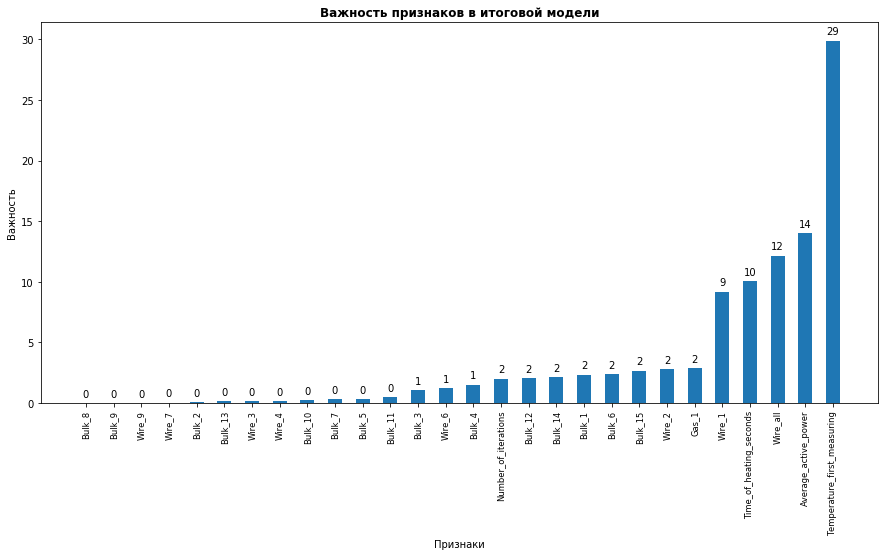

In [110]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.title("Важность признаков в итоговой модели", fontweight='bold', size='large')

plt.ylabel("Важность")
plt.xlabel("Признаки")
plt.xticks(range(len(range(len(model_importances.sort_values(by = 'importances')['columns'])))),
                     model_importances.sort_values(by = 'importances')['columns'], rotation=90, size='small')

plt.bar(range(len(model_importances.sort_values(by = 'importances')['columns'])),
        model_importances.sort_values(by = 'importances')['importances'],
        width = 0.5)

for i, v in enumerate(model_importances.sort_values(by = 'importances')['importances']):
    ax.text(i, v+0.5, "%d" %v, ha="center")
plt.show()

Видим, что факторы, которые внесли наибольший вклад:
- Температура до начала процесса;
- Активная мощность;
- Общий объем добавленных проволочных веществ;
- Общее время нагрева;
- Объем добавленного проволочного вещества 1.

Дальше идет заметное падение важности признаков.

Из интересных наблюдений это конечно - <b>Общий объем добавленных проволочных веществ</b>. Если вывод про изначальную температуру, мощность и время нагрева выглядит логично и без построения такой сложной модели, то найти закономерность между общим объемом добавленных проволочных веществ и конечной температуры, кажется не таким очевидным.

Также из наблюдений:
- Число итераций не так важно, как общее время нагрева. То есть большее влияет сколько мы суммарно греем, чем в сколько заходов.
- Проволочные материалы вносят больший вклад, чем сыпучие.
- Продувка газом имеет не такое большое влияние, как проволочные материалы. Но большее, чем сыпучие.

## Вывод

<b>Краткие выводы проекта:</b>

Выводы анализа данных уже были описаны в пунтке 3 "Выводы анализа данных и дальнейший план". 

Здесь мы не будем дублировать подробно результаты этого шага. Но немного пройдемся по тому, к чему привели шаги, которые запланировали там <b>для обработки и подготовке данных.</b>
- Больше 1 тыс партий пришлось удалить из чуть больше 3 тыс иходных. Половину из-за отсутствия целевого признака - температуры последнего замера (вероятно данные не успели прогрузить, или была ошибка в прогрузке именно этих партий). Еще примерно половину удалили из-за ошибок: ошибок в хронологии процесса и вылетов по показателям.
- Итого, для обучения модели осталось около 2 тыс партий.

- После агрегации всех данных до партий была проведена проверка на коллинеарность и 3 признака были удалены (Работа, Суммарное количество сухих веществ, и объем проволочного вещества 8). 
- Итого конечное чило признаков, участвующих в обучении было 29. Включая те, что мы добавили сами: суммарное количество проволочных веществ, число итераций, полная мощность, суммарное время нагрева в секундах.

<b>Моделировалие</b>


- Для прогнозирования использовались: Линейная регрессия, Случайный лес (регрессия), модели градиентного бустинга из библиотек LightGBM и CatBoost. 

- Также были попробованы элементарные модели, чтобы оценивать качество остальных моделей.

Результаты обучения моделей на тренировчной выборке с кроссвалидацией:


| N |       Model                | MAE  | Время обучения | 
|---|----------------------------|------------|----------|
| 1 | Median |   10.01  | Меньше 1 сек    | 
| 2 | Mean |   10.57  | Меньше 1 сек    |
| 3 | LinearRegression |   8.07  | Около 1 сек    |
| 4 | RandomForestRegressor |   6.75  | Около 1 мин    |
| 5 | LightGBM |   6.79  | Около 3 мин    |
| 6 | <b>CatBoost</b> |  <b> 6.31</b>| Около 10 мин    |

Модель CatBoostRegressor показала себя лучше всего, параметры:
- learning_rate: 0.005, 
- n_estimators: 3000,

- MAE на тренировочной выборке -  <b>6.31</b>,
- MAE на тестовой выборке -  <b>6.36</b>.

Это хороший результат тестирования, который очень близок к метрикам на тренировочной выборке, значит модель не переобучена. И прогнозирует температуру стабильно.

<b>Важность признаков</b>

Факторы, которые внесли наибольший вклад:

1. Температура до начала процесса;
2. Активная мощность;
3. Общий объем добавленных проволочных веществ;
4. Общее время нагрева;
5. Объем добавленного проволочного вещества 1.


Другие наблюдения:
- Из важных и неочевидных наблюдений: из всех веществ именно "Общий объем добавленных проволочных веществ" имеет самое большое влияние на величину конечной температуры.
- Число итераций не так важно, как общее время нагрева. То есть большее влияет сколько мы суммарно греем, чем в сколько заходов.
- Проволочные материалы вносят больший вклад, чем сыпучие.
- Продувка газом имеет не такое большое влияние, как проволочные материалы. Но большее, чем сыпучие.

<b>Разговор с бизнесом</b>

При презентации проекта бизнесу необходимо обсудить:

- <b>Качество данных</b>:
Выше мы уже описали найденные проблемы, основная отсутствие целевого признака по почти 500 партиям. Но также к ним добавились и ошибки в данных хронологии процесса, которых оказалось значительно много - около 400. Необходимо обсудить причины и понять как их устранить. Это важно для дальнейшего использования модели.


- <b>Модель</b>: 
Необходимо презентовать модель и указать, что она предсказывает с отпределенной ошибкой. Но она лучше элементраных моделей, а также ее предсказания стаблильны, так метрики на тренировочном сете данных и тестовом очень похожи.


- <b>Важность признаков</b>: 
Необходимо обратить внимание на закономерности, которые мы нашли выше. И особенно указать на то, что общий объем добавленных проволочных веществ вносит очень серьезный вклад в значение температуры.


Возможно потребуется произвести дополнительный анализ по итогам разговора и нам смогут предоставить больше данных, к примеру, по составу данных веществ и мы сможем помочь уменьшить потребляемую энергию в будущем.

## Отчет по проекту

Ниже можно найти итоговый отчет по выполнению проекта выше. Изначальный план по выполнению проекта был описан в пункте 3 "Выводы анализа данных и дальнейший план". 


<b>Какие пункты плана были выполнены, а какие — нет (поясните почему)?</b>
- Все шаги по разделу <b>"Подготовка данных"</b> удалось выполнить: данные были агрегированы до партий, признаки собраны в 1 таблицу, была проверена хронология процесса и выполнена проверка на коллинеарность.
- Шаги по разделу <b>"Данные, пропуски и ошибки"</b> также были осуществлены: Партии с ошибками и нереалистичными значениями были удалены, пропуски заполнены. Единственное, что их количество оказалось немного больше, изначально ожидаемого.
- Из сгененированных новых признаков, кроме запланированного числа итераций, также добавились: суммарное время нагрева, средние активные и реактивные мощности. Но не все из них прошли проверку на коллинеарность. Тем не менее, новые сгенерированные признаки: суммарное время нагрева и активная мощность оказались значительными для модели.
- Вопросы по <b>"Согласованию с бизнесом"</b> были обсуждены на консультации. Поэтому анализ и подготовка данных были выполнены с учетом информации, полученной на консультации.


- Большинство шагов по разделу <b>"Модель"</b> также были выполнены: данные разделены на выборки, масштабированы, обучены на элементарных и запланированных моделях с применением кроссвалидации, были рассмотрены разные гиперпараметры для модели.
- Выбор лучшей модели происходил по наибольшему MAE, лучшая модель была обучена на всем тренировочном сете и протестирована.
- Был произведен анализ важности признаков, написан вывод по проекту и работе модели.



- Из нереализованных шагов: при выборе модели оптимальное время работы модели не было учтено при выборе итоговой модели. Даже скорее наоборот лучшие результаты показала самая медленная модель. Но отрыв метрики по ней был существенный относительно более быстрых моделей.



<b>Какие трудности возникли и как вы их преодолели?</b>
- Было не очевидно, как правильно агрегировать до партий физические показатели. Помогли решить эти проблемы: консультация и поиск формул в интернете.
- Было трудно добиваться улучшения качества моделей. Изначально лучшая модель (также CatBoost) показывала значания около 6,4 MAE при обучении. Удалось понизить метрику за счет добавления новых сгенерерированных признаков, а также за счет изучения изначальных гиперпараметров моделей. 
- Оказалось, что стандартный набор параметров, который я использовала до этого был хуже значительно гиперпараметров по умолчанию (пр. число деревьев перебиралось до 100, а по умолчанию значение было 1000). Сократив количество перебираемых гиперпараметров, но приблизив их к оптимальным, качество значительно улучшилось как для LightGBM, так и для CatBoost. А также ушла проблема с умиранием ядра на некоторых моделях, когда перебиралось большое число гиперпараметров.

<b>Какие ключевые шаги в решении задачи выделили?</b>
- Выяснение деталей задачи и потребностей бизнеса на разговоре с бизнесом/консультации. Это сэкономило много времени. Предполагаю, что самостоятельное изучение заняло в разы больше времени и не исключило ошибки. Как вывод: всегда необходимо уточнять подробности изначальной задачи у заказчика.
- Гененирование признаков для обучения моделей. Качество модели значительно улучшалось после добавления некоторых признаков.
- Аккуратный исследовательский анализ - изучение признаков, выбросов и хронологии. Что позволило получить правильные данные для обучения моделей.
- Изучение библиотек, с помощью которых происходило обучение. Позволило улучшить качество моделей и оптимизировать процесс обучения.
- Анализ важности признаков итоговой модели. были получены интересные наблюдения, которые могут помочь бизнесу понять дальнейшие возможные пути работы над задачей.

<b>Какая ваша итоговая модель и какое у неё качество?</b>


Модель CatBoostRegressor показала себя лучше всего, гиперпараметры:
- learning_rate: 0.005, 
- n_estimators: 3000,

- MAE на тренировочной выборке -  <b>6.31</b>,
- MAE на тестовой выборке -  <b>6.36</b>.

Это хороший результат тестирования, который очень близок к метрикам на тренировочной выборке, значит модель не переобучена. И прогнозирует температуру стабильно.



## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *MAE* на тренировочной и тестовой выборке около 6,3